In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings(action='ignore')

## Part:1 K-means clustering

### 1a: Read orders, payments, customers data and assign them to Data Frames, separately. 

In [2]:
orders_df = pd.read_csv("Datasets/olist_orders_dataset.csv")
payments_df = pd.read_csv("Datasets/olist_order_payments_dataset.csv")
customers_df = pd.read_csv("Datasets/olist_customers_dataset.csv")

In [3]:
#Successfully created 3 separate dataframes named orders_df, payments_df and customers_df.

### 1b: Check if there are any duplicate records in any of the datasets.

In [4]:
orders_df.duplicated().sum()

0

In [5]:
payments_df.duplicated().sum()

0

In [6]:
customers_df.duplicated().sum()

0

In [7]:
#No duplicate records are present in any of the 3 dataframes.

### 1c: Check if there are any null values present in any of the datasets. Drop if any null values present in the datasets. 

In [8]:
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [9]:
payments_df.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [10]:
customers_df.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [11]:
#Orders_df has null values whereas payments and customers have 0 null values.
#Now let's drop null values present in orders df.

In [12]:
orders_df.dropna(inplace=True)

In [13]:
orders_df.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

### 2a: Change Data Types in order data, Change date columns into datetime, from strings. 

In [14]:
date_cols = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
for i in date_cols:
    orders_df[i]=pd.to_datetime(orders_df[i])
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


### 2b: Merge order data and customer data on customer_id into a new Data Frame.

In [15]:
merged_df_1 = orders_df.merge(customers_df, on='customer_id')

### 2c: Merge above formed Data Frame and payment data on order_id into a new Data Frame.

In [16]:
merged_df_2 = merged_df_1.merge(payments_df, on='order_id')

### 2d: Check the shape of the above dataset.

In [17]:
merged_df_2.shape

(100739, 16)

### 2e: Check the count of classes in order status column. Drop ‘cancelled orders’ from the order status as the count is very less.

In [18]:
merged_df_2['order_status'].value_counts()

delivered    100733
canceled          6
Name: order_status, dtype: int64

In [19]:
merged_df_2 = merged_df_2[merged_df_2['order_status'] != 'canceled']
merged_df_2['order_status'].value_counts()

delivered    100733
Name: order_status, dtype: int64

### 2f: Drop 'order_status', 'order_purchase_timestamp' columns from the dataset.

In [20]:
merged_df_2 = merged_df_2.drop(['order_status', 'order_purchase_timestamp'], axis=1)

In [21]:
merged_df_2.shape

(100733, 14)

In [22]:
#Column count has reduced to 14 from 16, after dropping two columns-order_status and order_purchase_timestamp.

### 2g: Drop 'order_delivered_carrier_date', 'order_delivered_customer_date','order_estimated_delivery_date', 'customer_unique_id', 'customer_zip_code_prefix' columns from the dataset.

In [23]:
merged_df_2 = merged_df_2.drop(['order_delivered_carrier_date', 'order_delivered_customer_date','order_estimated_delivery_date','customer_unique_id','customer_zip_code_prefix'], axis=1)
merged_df_2.shape

(100733, 9)

In [24]:
#Column count has reduced to 9 from 14, after dropping five columns-  'order_delivered_carrier_date', 
#'order_delivered_customer_date','order_estimated_delivery_date', 'customer_unique_id' and 'customer_zip_code_prefix'

### 2h: Check how many states are customers from?

In [25]:
merged_df_2['customer_state'].nunique()

27

### 2i: Check if any outliers present in all the numeric or continuous columns. Share your insights. Do not treat outliers here.

In [26]:
merged_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100733 entries, 0 to 100738
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   order_id              100733 non-null  object        
 1   customer_id           100733 non-null  object        
 2   order_approved_at     100733 non-null  datetime64[ns]
 3   customer_city         100733 non-null  object        
 4   customer_state        100733 non-null  object        
 5   payment_sequential    100733 non-null  int64         
 6   payment_type          100733 non-null  object        
 7   payment_installments  100733 non-null  int64         
 8   payment_value         100733 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 7.7+ MB


In [27]:
#As we can see, there are only 3 numerical columns present out of 9 columns.

In [28]:
numeric_columns = merged_df_2.select_dtypes(include=['number'])
numeric_columns.columns

Index(['payment_sequential', 'payment_installments', 'payment_value'], dtype='object')

In [29]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

for col in numeric_columns:
    outliers = find_outliers_IQR(merged_df_2[col])
    outlier_percentage = round((outliers.count() / merged_df_2[col].count()), 2)
    print('{} has {} outliers against total {} values that is {} %.'.format(col, outliers.count(), merged_df_2[col].count(), outlier_percentage))

payment_sequential has 4357 outliers against total 100733 values that is 0.04 %.
payment_installments has 6097 outliers against total 100733 values that is 0.06 %.
payment_value has 7695 outliers against total 100733 values that is 0.08 %.


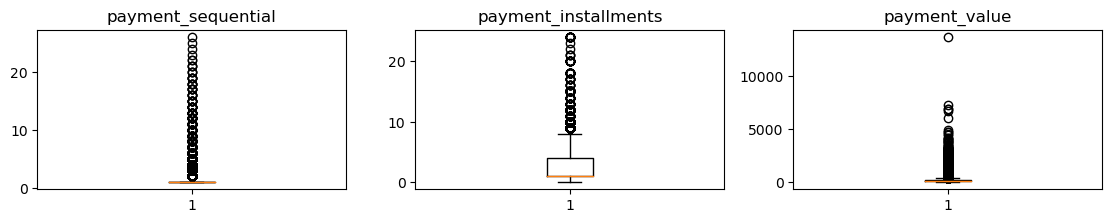

In [30]:
# outlier detection using boxplot
plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(6, 4, i + 1)
    plt.boxplot(merged_df_2[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

### 3a: Perform univariate, bivariate analysis on the data. Share your insights.

In [31]:
def labeled_barplot(data, feature, perc=False, n=None):

    total = len(data[feature]) 
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(100 * p.get_height() / total) 
        else:
            label = p.get_height() 

        x = p.get_x() + p.get_width() / 2 
        y = p.get_height() 

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        ) 

    plt.show() 

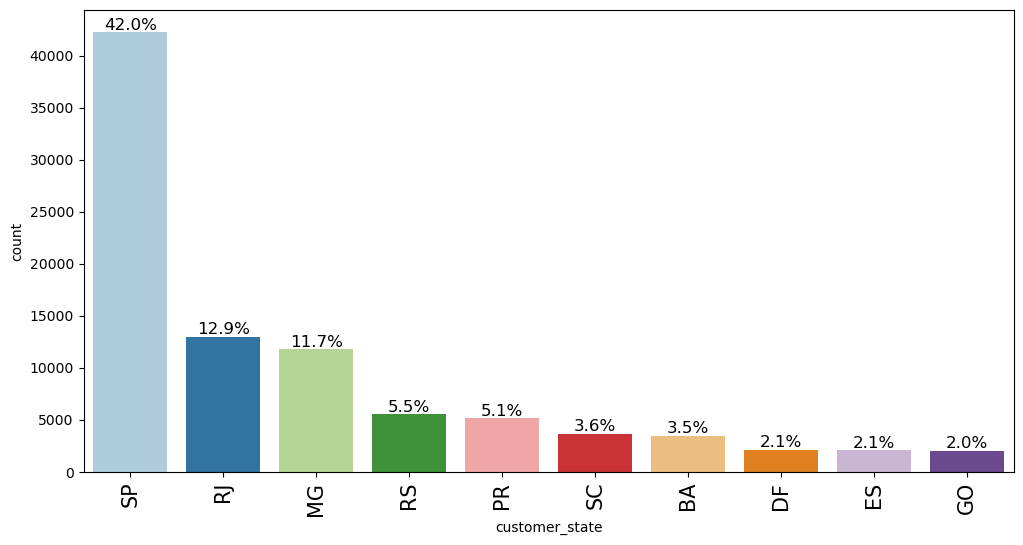

In [32]:
labeled_barplot(merged_df_2, 'customer_state', n=10, perc=True)

In [33]:
#42% customers are from Sao Paulo state.

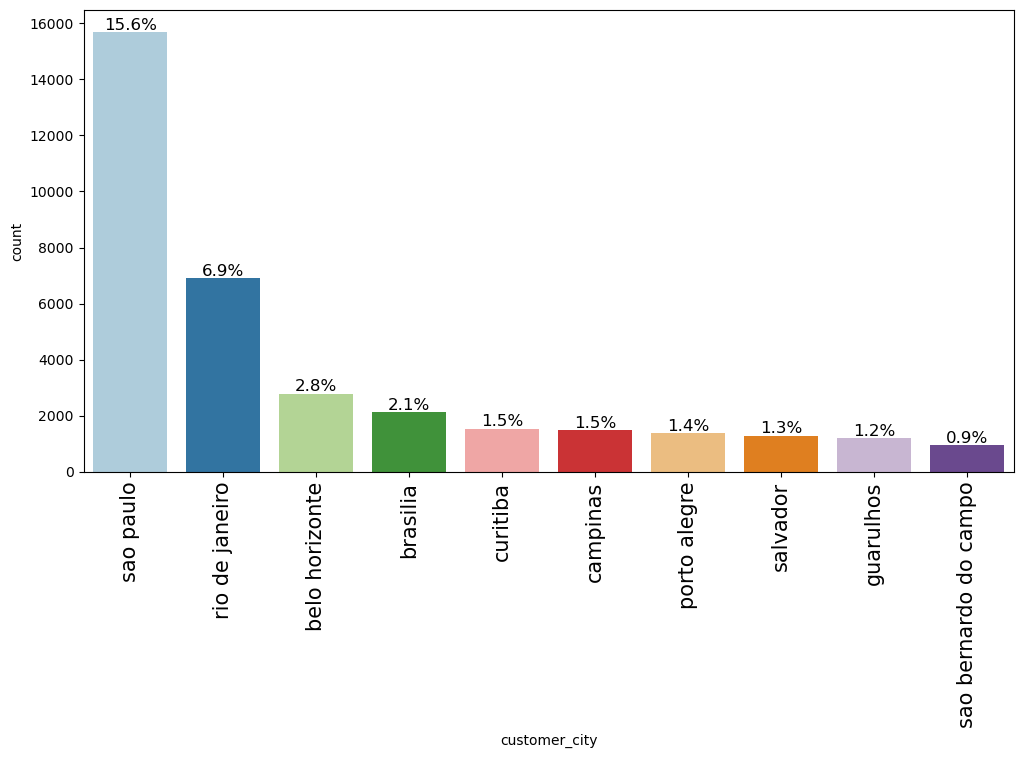

In [34]:
labeled_barplot(merged_df_2, 'customer_city', n=10, perc=True)

In [35]:
#In sao paulo state, most customers are from sao paulo city(15.6%) and rio de janerio (6.9%).

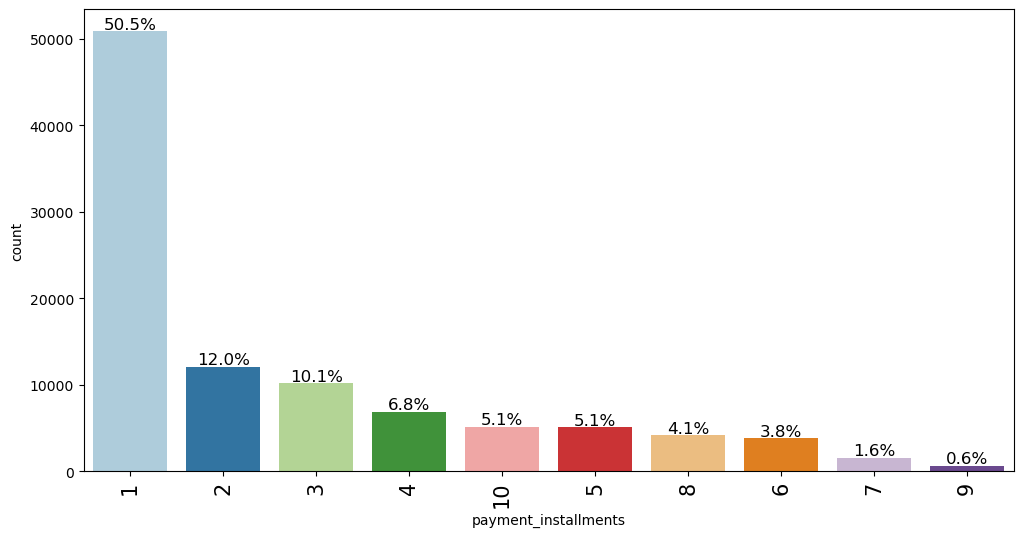

In [36]:
labeled_barplot(merged_df_2, 'payment_installments', n=10, perc=True)

In [37]:
#50% of the customers paid the bill in single installment.

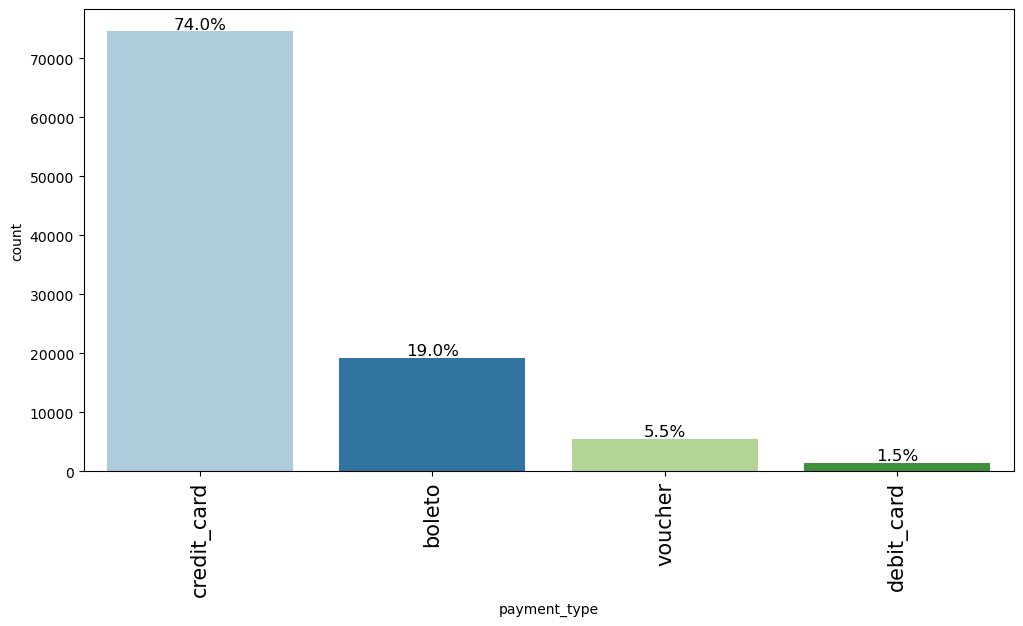

In [38]:
labeled_barplot(merged_df_2, 'payment_type', n=10, perc=True)

In [39]:
#Credit card is the most prefered method of payment.(74%)

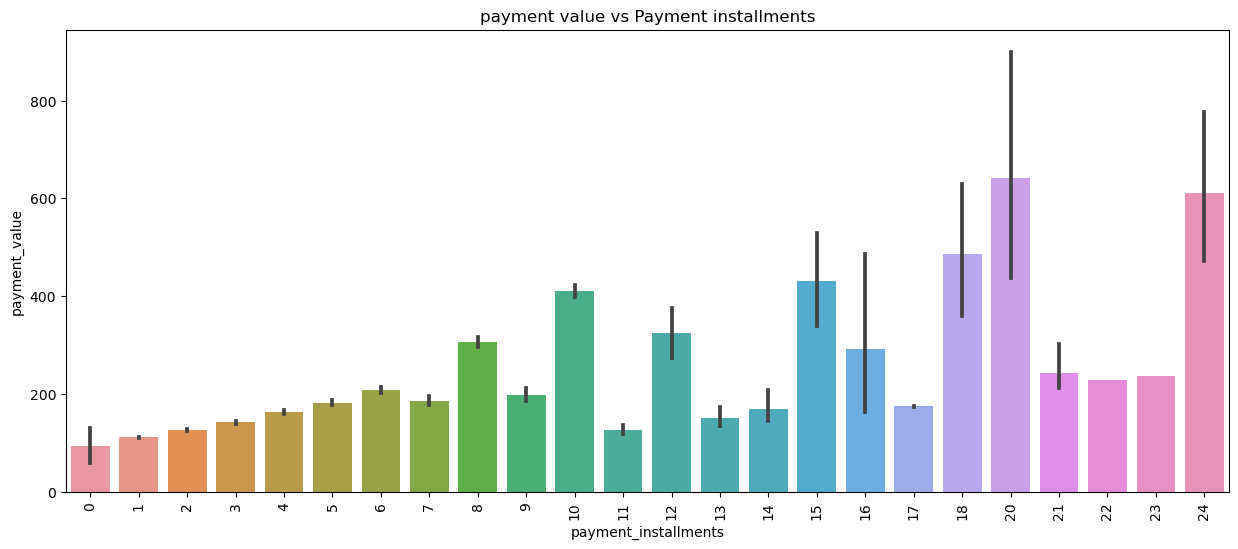

In [40]:
#Bivariate analysis:
plt.figure(figsize=(15, 6))
sns.barplot(x='payment_installments', y='payment_value', data=merged_df_2)
plt.xticks(rotation=90)
plt.title('payment value vs Payment installments')
plt.show()

In [41]:
#Generally high payment values are associated with large number of payment installments.

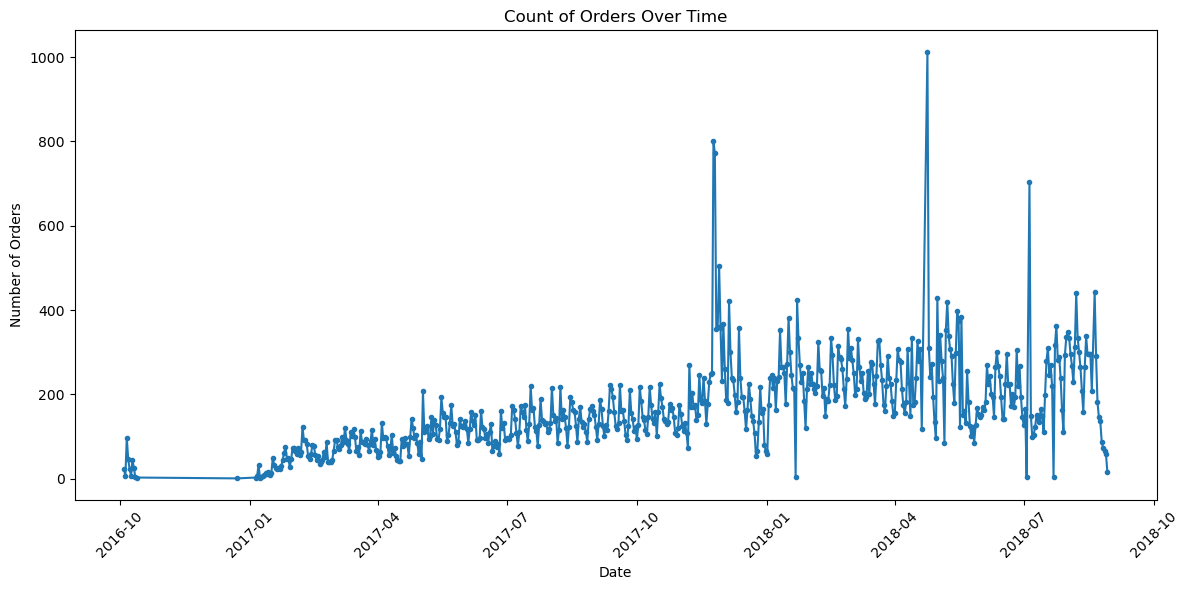

In [42]:
order_count_by_date = merged_df_2.groupby(merged_df_2['order_approved_at'].dt.date).size()
plt.figure(figsize=(12, 6))
plt.plot(order_count_by_date.index, order_count_by_date.values, marker='.', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.title('Count of Orders Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
#Sudden rise in number of orders in quarter-4 of 2017 compared to previous months.
#Business has been growing with time.

### 3b: Perform multivariate analysis on the data. Share your insights.

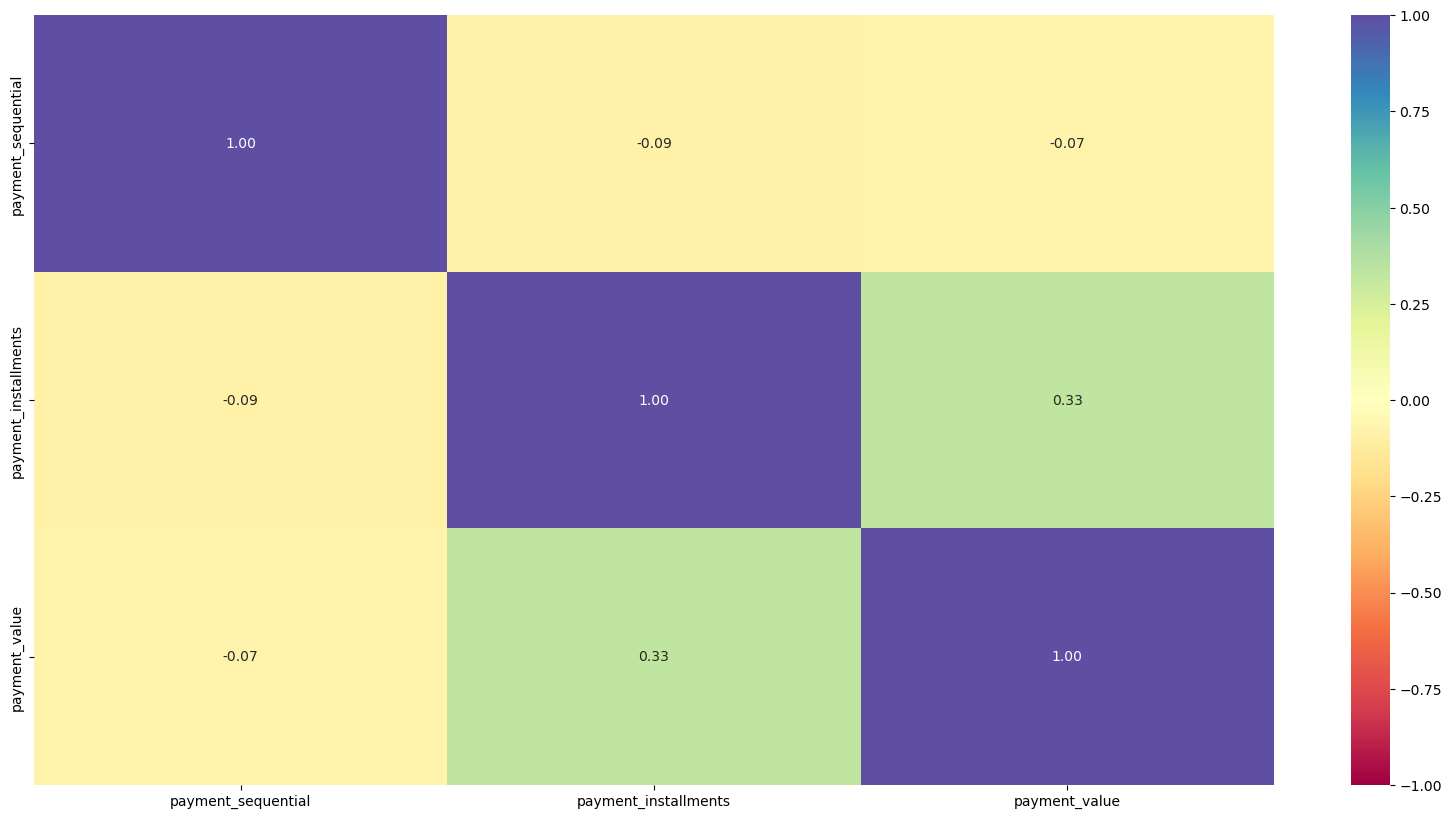

In [44]:
plt.figure(figsize=(20,10))
sns.heatmap(numeric_columns.corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap="Spectral")
plt.show()

In [45]:
summary = merged_df_2.describe()
summary

,payment_sequential,payment_installments,payment_value
count,100733.000000,100733.000000,100733.000000
mean,1.088392,2.851915,153.067359
std,0.652802,2.684557,214.471078
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.780000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.290000
max,26.000000,24.000000,13664.080000


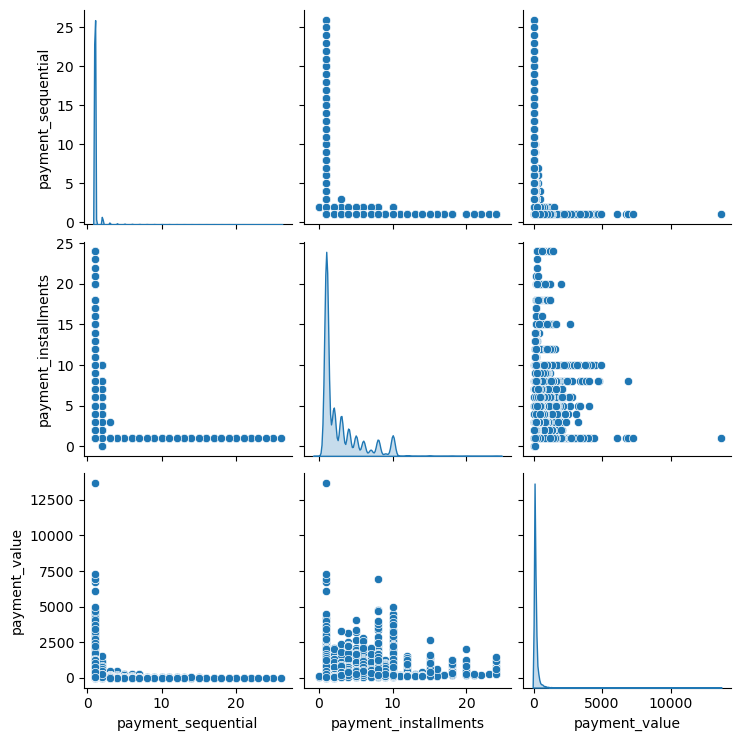

In [46]:
sns.pairplot(numeric_columns, diag_kind ='kde')

<b>Observations:</b>

    1. Payment value and payment installments are positively correlated (0.33) which makes sense as orders with high payment values are difficult to pay in one go.
    2. Most payments (75%) have 4 or fewer installments.
    3. The distribution of payment values is positively skewed, with a significant difference between the 75th percentile (171.29) and the maximum value (13,664.08).

### 4a: Drop outliers present in ‘payment_value’ column and assign to a new Data Frame

In [47]:
payment_outliers_count=find_outliers_IQR(merged_df_2['payment_value'])
payment_outliers_count.count()

7695

In [48]:
Q1 = merged_df_2['payment_value'].quantile(0.25)
Q3 = merged_df_2['payment_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_merged_df_2 = merged_df_2[(merged_df_2['payment_value'] >= lower_bound) & (merged_df_2['payment_value'] <= upper_bound)]

In [49]:
for col in numeric_columns:
    outliers = find_outliers_IQR(filtered_merged_df_2[col])
    outlier_percentage = round((outliers.count() / filtered_merged_df_2[col].count()), 2)
    print('{} has {} outliers against total {} values that is {} %.'.format(col, outliers.count(), filtered_merged_df_2[col].count(), outlier_percentage))

payment_sequential has 4285 outliers against total 93038 values that is 0.05 %.
payment_installments has 8473 outliers against total 93038 values that is 0.09 %.
payment_value has 2417 outliers against total 93038 values that is 0.03 %.


In [50]:
#Outlier count has been reduced significantly from 7695 to 2417, it can be reduced further by multiplying IQR with a smaller number.

In [51]:
#Filtered_merged_df_2 is the new dataframe.

### 4b: Check the Recency score of each customer i.e., Days since the last purchase

In [52]:
max_date=filtered_merged_df_2.groupby('customer_id')['order_approved_at'].max().reset_index()
max_date=max_date.rename({'order_approved_at':'most_recent'},axis=1)
max_date.head()

,customer_id,most_recent
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:35:32
1,000161a058600d5901f007fab4c27140,2017-07-16 09:55:12
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:15:20
3,0002414f95344307404f0ace7a26f1d5,2017-08-17 03:10:27
4,000379cdec625522490c315e70c7a9fb,2018-04-04 03:10:19


In [53]:
max_date['r_score']=(max_date['most_recent'].max()-max_date['most_recent']).dt.days
max_date.head()

,customer_id,most_recent,r_score
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:35:32,287
1,000161a058600d5901f007fab4c27140,2017-07-16 09:55:12,409
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:15:20,547
3,0002414f95344307404f0ace7a26f1d5,2017-08-17 03:10:27,377
4,000379cdec625522490c315e70c7a9fb,2018-04-04 03:10:19,147


### 4c: Check the Frequency score of each customer i.e., How many times the customer makes transaction

In [54]:
n_transaction=filtered_merged_df_2.groupby('customer_id')['order_id'].count().reset_index()
n_transaction=n_transaction.rename({'order_id': 'f_score'},axis=1)
n_transaction.head()

,customer_id,f_score
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1


### 4d: Check the Monetary value of each customer i.e., Average Purchase Value form the customer

In [55]:
avg_purchase=filtered_merged_df_2.groupby('customer_id')['payment_value'].mean().reset_index()
avg_purchase=avg_purchase.rename({'payment_value': 'm_score'},axis=1)
avg_purchase.head()

,customer_id,m_score
0,00012a2ce6f8dcda20d059ce98491703,114.74
1,000161a058600d5901f007fab4c27140,67.41
2,0001fd6190edaaf884bcaf3d49edf079,195.42
3,0002414f95344307404f0ace7a26f1d5,179.35
4,000379cdec625522490c315e70c7a9fb,107.01


### 4e: Check how many customers are there in our data by checking ‘customer_id’.

In [56]:
filtered_merged_df_2.shape

(93038, 9)

In [57]:
filtered_merged_df_2['customer_id'].nunique()

88893

In [58]:
#We have 88893 unique customers out of 93038 order records.

### 4f: Merge Recency score and Frequency score on ‘customer_id’ and assign to a new Data Frame.

In [59]:
merge=max_date.merge(n_transaction,how='left',on='customer_id')

### 4g: Merge above created Data Frame (4.f) and Monetary value on customer_id and assign to a new Data Frame.

In [60]:
merge=merge.merge(avg_purchase, how='left', on='customer_id')

### 4h: Create a new Data Frame by selecting 'customer_id', 'Recency score', 'Frequency score', ‘Monetary value' columns.

In [61]:
df_rfm=merge[['customer_id','r_score','f_score','m_score']]
df_rfm
df_rfm_with_customerid=df_rfm.copy()

### 5a: Drop ‘customer_id’ from RFM data.

In [62]:
df_rfm = df_rfm.drop(['customer_id'], axis=1)
df_rfm.columns

Index(['r_score', 'f_score', 'm_score'], dtype='object')

### 5b: Scale the above RFM data

In [63]:
scaler = StandardScaler()
df_rfm_copy = df_rfm.copy()
scaled_data = scaler.fit_transform(df_rfm_copy)

In [64]:
df_rfm_scaled = pd.DataFrame(scaled_data, columns=df_rfm_copy.columns)

### 5c: Apply K-Means clustering for 1 to 10 clusters.

In [65]:
clusters = range(1, 11)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(df_rfm_scaled)
    prediction = model.predict(df_rfm_scaled)
    distortion = (
        sum(
            np.min(cdist(df_rfm_scaled, model.cluster_centers_, "euclidean"), axis=1)
        )
        / df_rfm_scaled.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

Number of Clusters: 1 	Average Distortion: 1.3646900359828649
Number of Clusters: 2 	Average Distortion: 1.1010638574736762
Number of Clusters: 3 	Average Distortion: 0.8938400176128347
Number of Clusters: 4 	Average Distortion: 0.8612551069254598
Number of Clusters: 5 	Average Distortion: 0.8109847624807635
Number of Clusters: 6 	Average Distortion: 0.733140343334435
Number of Clusters: 7 	Average Distortion: 0.6608799861343934
Number of Clusters: 8 	Average Distortion: 0.6489978073180763
Number of Clusters: 9 	Average Distortion: 0.5918465348367922
Number of Clusters: 10 	Average Distortion: 0.5529963868873942


### 5d: Plot a visual and find elbow point.

Text(0.5, 1.0, 'The Elbow Method')

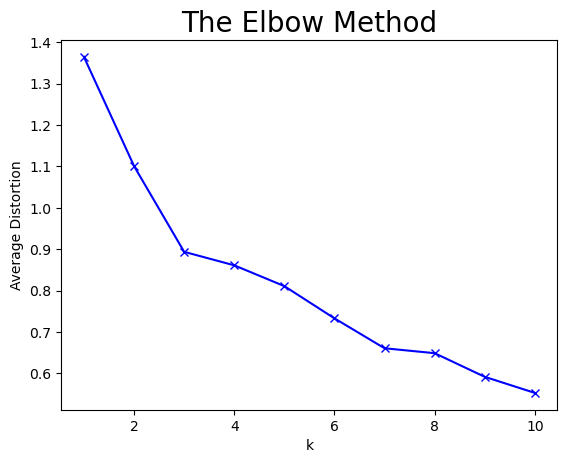

In [66]:
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("The Elbow Method", fontsize=20)

In [67]:
# Beyond K=3, the decrease in average distortion is less pronounced which makes k=3 an optimal value. 

### 5e: Train a K-means clustering model once again on the optimal number of clusters.

In [68]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_rfm_scaled)

KMeans(n_clusters=3, random_state=0)

### 5f: Add a new feature in the RFM Data Frame which will have labels based upon cluster value.

In [69]:
df_rfm["K_means_segments"] = kmeans.labels_
df_rfm.head()

,r_score,f_score,m_score,K_means_segments
0,287,1,114.74,0
1,409,1,67.41,0
2,547,1,195.42,0
3,377,1,179.35,1
4,147,1,107.01,2


### 5g: Do cluster profiling by grouping clusters by their mean

In [70]:
cluster_profile = df_rfm.groupby("K_means_segments").mean()
cluster_profile["count_in_each_segment"] = (df_rfm.groupby("K_means_segments")["r_score"].count().values)
cluster_profile.style.highlight_max(color="lightyellow", axis=0)

,r_score,f_score,m_score,count_in_each_segment
K_means_segments,,,,
0,415.698189,1.093885,86.898687,26394
1,212.261220,1.004000,217.710947,20500
2,140.109860,1.037739,77.992151,41999


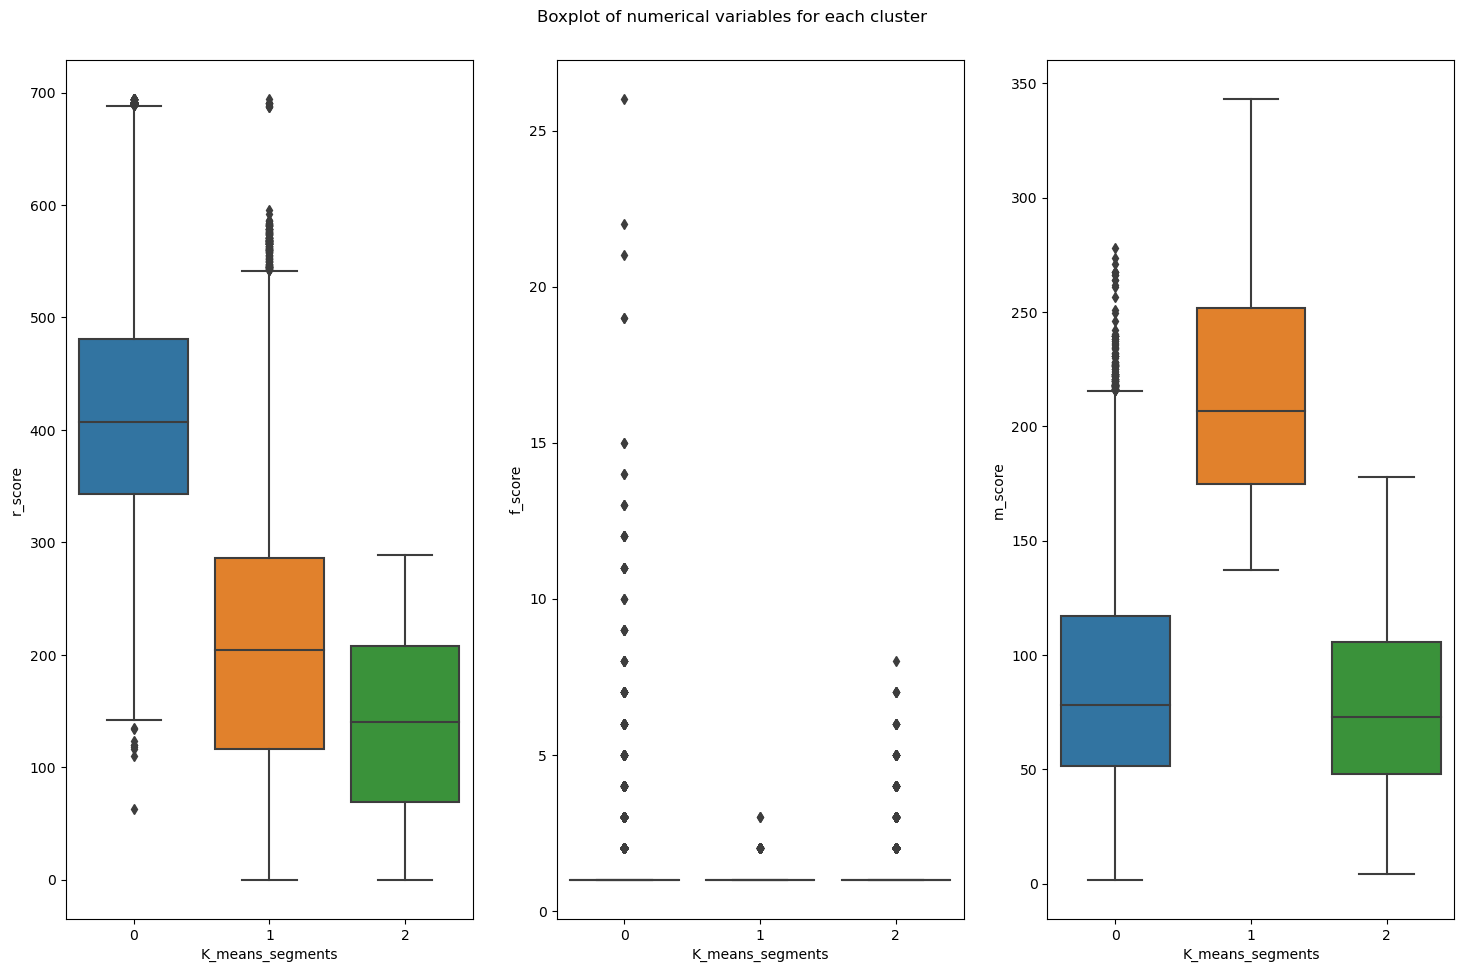

In [71]:
numerical_col = ['r_score', 'f_score', 'm_score']

plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(numerical_col):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df_rfm, x="K_means_segments", y=variable)

plt.tight_layout(pad=2.0)

### 5h: Share your interpretation on clusters. And explain the customer behaviour based on their Recency, Frequency and Monetary score from the clusters formed.

1. Cluster 0 appears to have customers who haven't shopped in a long time but make mid-value purchases with a slightly lower purchase frequency.
2. Cluster 1 has customers who purchase slightly more frequently, but with highest monetary values and least frequently.
3. Cluster 2 has the largest number of customers and seems to consist of customers who have made lower-value purchases, most recently, but less frequently.

### 5i: Give any 3 Business Recommendations.

1. Customers in Cluster 0 may respond well to discounts or promotions that emphasize cost savings, which will also help in descreasing their r_score as cost saving items or programs may lure them in.
2. Cluster 1 customers are high value customers as they have the highest m_score, cab be provided with early access to sales, special discounts, or loyalty points for every purchase as they have decent f_score.
3. Cluster 2 customers  might be the customers who shop for daily grocery or everyday use items as their m_score is low but f_score is decent with high r_score showing recent purchases, so marketing ads can be shown to them accordingly.

## Part:2 Principal Components Analysis

### 1a: Read all datasets and assign them to Data Frames separately.

In [72]:
df_orders = pd.read_csv("Datasets/olist_orders_dataset.csv")
df_order_items = pd.read_csv("Datasets/olist_order_items_dataset.csv")
df_products = pd.read_csv("Datasets/olist_products_dataset.csv")
df_category_name_eng = pd.read_csv("Datasets/product_category_name_translation.csv")
df_customers = pd.read_csv("Datasets/olist_customers_dataset.csv")
df_sellers = pd.read_csv("Datasets/olist_sellers_dataset.csv")
df_payments = pd.read_csv("Datasets/olist_order_payments_dataset.csv")
df_reviews = pd.read_csv("Datasets/olist_order_reviews_dataset.csv")

In [73]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [74]:
df_order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [75]:
df_products.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [76]:
df_category_name_eng.columns

Index(['product_category_name', 'product_category_name_english'], dtype='object')

In [77]:
df_customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [78]:
df_sellers.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

In [79]:
df_payments.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [80]:
df_reviews.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

### 1b: Merge Customer data and Orders data on customer_id, assign it to a new Data Frame and name it as clients.

In [81]:
clients = df_customers.merge(df_orders, on='customer_id')

### 1c: Merge order_payments data and order_reviews data on order_id, assign it to a new Data Frame and name it as orders.

In [82]:
orders = df_payments.merge(df_reviews, on='order_id')

### 1d: Merge seller data and order_items data on seller_id, assign it to a new Data Frame and name it as seller.

In [83]:
seller= df_sellers.merge(df_order_items, on='seller_id')

### 1e: Merge product data and product_category_name_translation data on product_category_name, assign it to a new Data Frame and name it as product

In [84]:
product= df_products.merge(df_category_name_eng, on='product_category_name')

### 1f: Here merge above created new Data Frames clients and orders on order_id, assign it to a new Data Frame and name it as df1.


In [85]:
df1= clients.merge(orders, on='order_id')

### 1g: Here merge above created new Data Frames seller and product on product_id, assign it to a new Data Frame and name it as df2.

In [86]:
df2= seller.merge(product, on='product_id')

### 1h: Finally, merge df1 and df2 on order_id, assign it to a new Data Frame by giving a suitable name.

In [87]:
retail=df1.merge(df2, on='order_id')

### 1i: Print the shape of Final Data set.

In [88]:
retail.shape

(115609, 40)

### 2a: Check the percentage of null values in each column.

In [89]:
def check_missing_values(Dframe):
    Missing_values=pd.DataFrame(Dframe.isnull().sum(), columns= ['Number of missing values'])
    Missing_values['%age of missing values']=Dframe.isnull().sum() * 100 / len(Dframe)
    return Missing_values

check_missing_values(retail)

,Number of missing values,%age of missing values
customer_id,0,0.000000
customer_unique_id,0,0.000000
customer_zip_code_prefix,0,0.000000
customer_city,0,0.000000
customer_state,0,0.000000
order_id,0,0.000000
order_status,0,0.000000
order_purchase_timestamp,0,0.000000
order_approved_at,14,0.012110
order_delivered_carrier_date,1195,1.033657


### 2b: Drop all the columns having more than 50% null values.

In [90]:
retail.drop(['review_comment_title','review_comment_message'],axis=1,inplace=True)

### 2c: Drop all the null values present in the data.

In [91]:
retail.dropna(inplace=True)

In [92]:
check_missing_values(retail)

,Number of missing values,%age of missing values
customer_id,0,0.0
customer_unique_id,0,0.0
customer_zip_code_prefix,0,0.0
customer_city,0,0.0
customer_state,0,0.0
order_id,0,0.0
order_status,0,0.0
order_purchase_timestamp,0,0.0
order_approved_at,0,0.0
order_delivered_carrier_date,0,0.0


### 2d: Select only numerical variables for further analysis. 

In [93]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113193 entries, 0 to 115608
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    113193 non-null  object 
 1   customer_unique_id             113193 non-null  object 
 2   customer_zip_code_prefix       113193 non-null  int64  
 3   customer_city                  113193 non-null  object 
 4   customer_state                 113193 non-null  object 
 5   order_id                       113193 non-null  object 
 6   order_status                   113193 non-null  object 
 7   order_purchase_timestamp       113193 non-null  object 
 8   order_approved_at              113193 non-null  object 
 9   order_delivered_carrier_date   113193 non-null  object 
 10  order_delivered_customer_date  113193 non-null  object 
 11  order_estimated_delivery_date  113193 non-null  object 
 12  payment_sequential            

In [94]:
num_col = retail.select_dtypes(include=['number'])
num_col.columns

Index(['customer_zip_code_prefix', 'payment_sequential',
       'payment_installments', 'payment_value', 'review_score',
       'seller_zip_code_prefix', 'order_item_id', 'price', 'freight_value',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm'],
      dtype='object')

In [95]:
num_columns = num_col.drop(['customer_zip_code_prefix', 'seller_zip_code_prefix','order_item_id'], axis=1)
#Dropping these as they are not relevant.

### 2e: Standardize the Data.

In [96]:
scaler = StandardScaler()
scaled_retail = pd.DataFrame(scaler.fit_transform(num_columns), columns = num_columns.columns)
scaled_retail.head

<bound method NDFrame.head of         payment_sequential  payment_installments  payment_value  review_score  \
0                -0.132259             -0.339555      -0.093445     -0.061300   
1                -0.132259              1.819364       0.620455      0.681687   
2                -0.132259              1.459544      -0.052340      0.681687   
3                -0.132259             -0.699375       0.006594      0.681687   
4                -0.132259              1.819364       0.305424      0.681687   
...                    ...                   ...            ...           ...   
113188           -0.132259              1.099724      -0.313319     -0.061300   
113189           -0.132259              0.020265      -0.160857      0.681687   
113190           -0.132259              0.739904      -0.437242     -2.290263   
113191           -0.132259             -0.339555       2.042086      0.681687   
113192           -0.132259             -0.699375      -0.566956      0.681687  

### 3a: Apply PCA on the data with 10 components

In [97]:
pca = PCA(n_components=10)
data_with_pca = pca.fit_transform(scaled_retail)

### 3b: Visualize Cumulative Variance Explained with Number of Components.

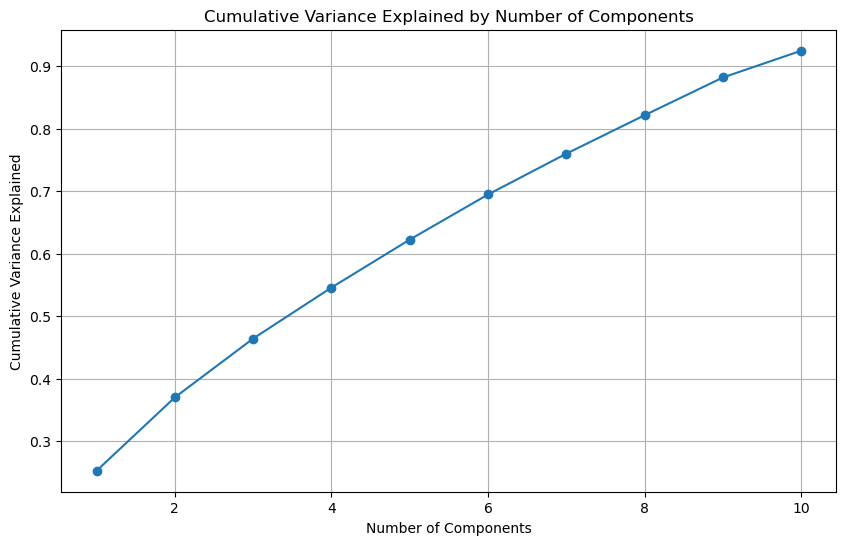

In [98]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Variance Explained by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.show()

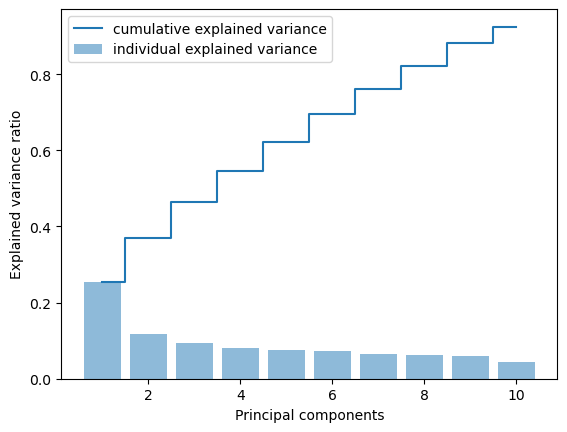

In [99]:
plt.bar(range(1,11),explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,11),cumulative_variance, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

### 3c: Draw a horizontal line on the above plot to highlight the threshold of 90%

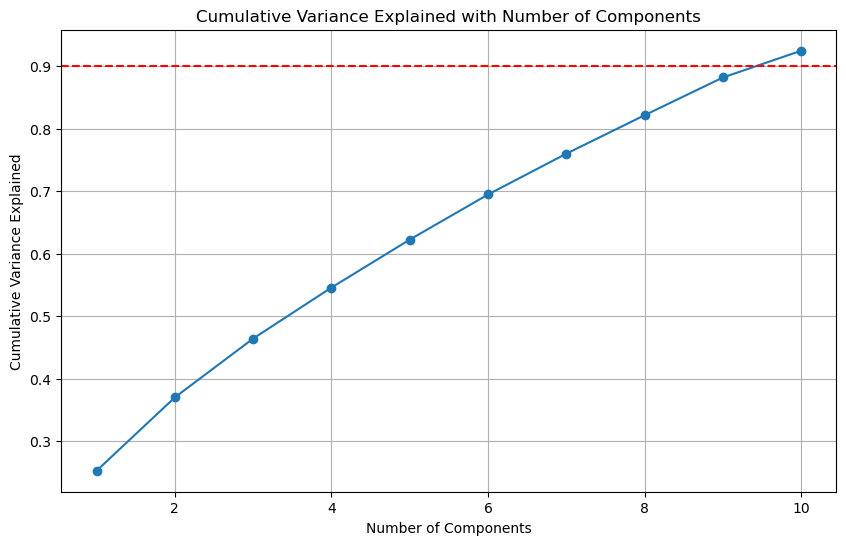

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Variance Explained with Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Threshold')
plt.show()

### 3d: Check how much variance does 2 PCA’s explains.

In [101]:
# Calculate the variance explained by the first two components
variance_explained_by_2_PCs = explained_variance[0] + explained_variance[1]
print(f"Variance Explained by the First 2 PCs: {variance_explained_by_2_PCs:.2%}")

Variance Explained by the First 2 PCs: 37.03%


### 3e: Apply PCA on the scaled data with 2 components and store results in a Data Frame.

In [102]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_retail)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df

,PC1,PC2
0,2.598878,-1.722173
1,4.152468,-1.191633
2,2.132214,-0.664904
3,2.682316,-1.756239
4,1.664754,-0.355876
...,...,...
113188,-0.369170,0.082866
113189,-0.246698,0.214433
113190,-0.429343,0.036548
113191,1.067584,2.728791


### 3f: Apply K-Means clustering with 3 clusters

In [103]:
kmeans = KMeans(n_clusters=3)

### 3g: Fit above formed PCA data (3.e) to K- Means clustering with 3 clusters (3.f)

In [104]:
kmeans.fit(pca_df)

# Getting the cluster assignments for each data point
cluster_labels = kmeans.labels_

# Adding the cluster labels to the DataFrame
pca_df['Cluster'] = cluster_labels
pca_df

,PC1,PC2,Cluster
0,2.598878,-1.722173,0
1,4.152468,-1.191633,1
2,2.132214,-0.664904,0
3,2.682316,-1.756239,0
4,1.664754,-0.355876,0
...,...,...,...
113188,-0.369170,0.082866,2
113189,-0.246698,0.214433,2
113190,-0.429343,0.036548,2
113191,1.067584,2.728791,2


### 3h: Do cluster profiling by grouping clusters by their mean

In [105]:
cluster_groups = pca_df.groupby('Cluster')
cluster_means = cluster_groups.mean()
cluster_means

,PC1,PC2
Cluster,,
0,1.091817,-0.915137
1,5.888238,1.101917
2,-0.841580,0.319148


### 3i: Share your interpretation on clusters. And explain the customer behaviour based on their Recency, Frequency and Monetary score from the clusters formed.

In [106]:
pc_comps = ['PC1', 'PC2']
data_pca = pd.DataFrame(np.round(pca.components_[:4,:],2), index = pc_comps, columns = scaled_retail.columns)
data_pca.T

,PC1,PC2
payment_sequential,-0.00,-0.16
payment_installments,0.21,0.22
payment_value,0.35,0.46
review_score,-0.03,-0.03
price,0.37,0.45
freight_value,0.41,-0.02
product_name_lenght,0.03,0.02
product_description_lenght,0.09,0.35
product_photos_qty,0.03,0.10
product_weight_g,0.45,-0.23


In [107]:
cluster_profile = df_rfm.groupby("K_means_segments").mean()
cluster_profile["count_in_each_segment"] = (df_rfm.groupby("K_means_segments")["r_score"].count().values)
cluster_profile.style.highlight_max(color="lightyellow", axis=0)

,r_score,f_score,m_score,count_in_each_segment
K_means_segments,,,,
0,415.698189,1.093885,86.898687,26394
1,212.261220,1.004000,217.710947,20500
2,140.109860,1.037739,77.992151,41999


Insight:
<b>The first principal component, PC1, seems to be related to products which are bulky as product weight, length, height and width are highly positive with large freight value which again indicates bulky products.</b>

1. Customers in Cluster 0 may respond well to discounts or promotions that emphasize cost savings, which will also help in descreasing their r_score as cost saving items or programs may lure them in.
2. Cluster 1 customers are high value customers as they have the highest m_score, cab be provided with early access to sales, special discounts, or loyalty points for every purchase as they have decent r_score.
3. Cluster 2 customers  might be the customers who shop for daily grocery or everyday use items as their m_score is low but f_score is decent with high r_score showing recent purchases, so marketing ads can be shown to them accordingly.